In [94]:
#!pip install scikit-plot

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [96]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [97]:
df_train = pd.read_csv('train_nolog.csv')

In [98]:
del df_train['originalTitle']
del df_train['rating']
del df_train['titleType']
del df_train['countryOfOrigin']
del df_train['isAdult']
del df_train['canHaveEpisodes']

In [99]:
# Dividere i generi in liste
df_train['genres'] = df_train['genres'].str.split(',')

In [100]:
# Espandere i generi in righe separate (es. da Movie1 -> Action|Comedy a Movie1 -> Action, Movie1 -> Comedy )
df_train = df_train.explode('genres').reset_index(drop=True)

In [101]:
X_train = df_train.drop(columns=['genres'])
y_train = df_train['genres']

Carichiamo test_nolog e creiamo le variabili

In [102]:
df_test = pd.read_csv('test_nolog.csv')

In [103]:
del df_test['originalTitle']
del df_test['rating']
del df_test['titleType']
del df_test['countryOfOrigin']
del df_test['isAdult']
del df_test['canHaveEpisodes']

In [104]:
# Dividere i generi in liste
df_test['genres'] = df_test['genres'].str.split(',')

In [105]:
# Espandere i generi in righe separate (es. da Movie1 -> Action|Comedy a Movie1 -> Action, Movie1 -> Comedy )
df_test = df_test.explode('genres').reset_index(drop=True)

In [106]:
X_test = df_test.drop(columns=['genres'])
y_test = df_test['genres']

### Normalization

In [107]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [108]:
norm = MinMaxScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

# KNN

In [109]:
from sklearn.neighbors import KNeighborsClassifier

In [199]:
clf = KNeighborsClassifier(n_neighbors=4, metric="euclidean", weights="uniform")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=4)

In [200]:
#predizione dei valori
y_test_pred = clf.predict(X_test_norm)
y_test_pred

array(['Action', 'Action', 'Comedy', ..., 'Adult', 'Action', 'Reality-TV'],
      dtype=object)

In [201]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.2041899980691253


In [202]:
# score: Return the mean accuracy on the given test data and labels.
clf.score(X_test_norm, y_test)

0.2041899980691253

In [203]:
print("F1:", f1_score(y_test, y_test_pred, average="macro"))
print("F1:", f1_score(y_test, y_test_pred, average="micro"))
print("F1:", f1_score(y_test, y_test_pred, labels=[1], average="micro"))
print("F1:", f1_score(y_test, y_test_pred, labels=[1], average="macro"))

F1: 0.10560217127533157
F1: 0.2041899980691253
F1: 0.0
F1: 0.0


C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [204]:
print(classification_report(y_test, y_test_pred))

C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Action       0.10      0.31      0.15       606
       Adult       0.15      0.36      0.21       133
   Adventure       0.10      0.13      0.11       537
   Animation       0.19      0.19      0.19       490
   Biography       0.02      0.03      0.02        89
      Comedy       0.23      0.34      0.27      1663
       Crime       0.14      0.11      0.12       515
 Documentary       0.24      0.22      0.23       580
       Drama       0.27      0.28      0.28      1964
      Family       0.18      0.04      0.07       416
     Fantasy       0.16      0.03      0.06       211
   Film-Noir       0.00      0.00      0.00         4
   Game-Show       0.13      0.04      0.06        81
     History       0.00      0.00      0.00       137
      Horror       0.17      0.06      0.09       242
       Music       0.11      0.02      0.04       188
     Musical       0.09      0.01      0.02        85
     Mystery       0.00    

C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


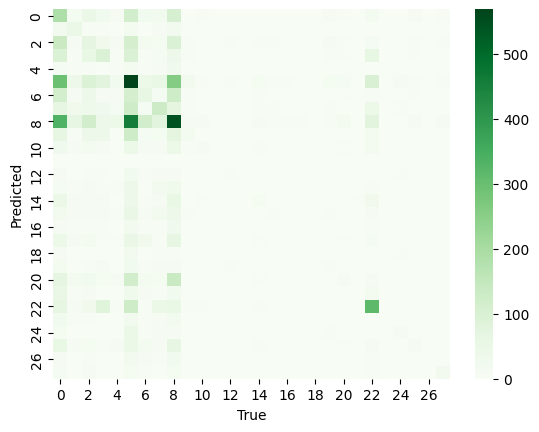

In [205]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=False, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [206]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(X_test_norm)
y_test_pred_proba[0:10]

array([[0.25, 0.  , 0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.  , 0.25, 0.  , 0.  ,
        0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.5 , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0. 

In [210]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test_pred_proba, y_test)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

ValueError: The target y is not binary. Got continuous-multioutput type of target.